In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [2]:
from scipy import ndimage

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Dataset definition

In [6]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [7]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [8]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [9]:
import torchvision
from torchvision import datasets, models, transforms

In [10]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
BATCH_SIZE = 12
EPOCHS = 300

In [13]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

### Overfitting on single batch of data

In [14]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [15]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [16]:
train_data_single_batch = next(iter(train_dataloader))

In [17]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [18]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [19]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [25]:
output.shape

torch.Size([12, 1])

In [20]:
output

tensor([[ 4.5717e-01],
        [ 9.2901e-02],
        [ 1.2787e-01],
        [-4.3980e-04],
        [ 4.6487e-01],
        [ 2.3853e-02],
        [ 2.3165e-01],
        [ 7.0853e-01],
        [-1.9488e-02],
        [-2.5317e-02],
        [ 1.8252e-01],
        [ 9.2214e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[ 63.3000],
        [ 74.5000],
        [ 75.5000],
        [ 49.5000],
        [ 63.3000],
        [ 86.3000],
        [ 89.5000],
        [ 66.3000],
        [126.0000],
        [ 73.3000],
        [135.0000],
        [ 46.5000]], device='cuda:0', dtype=torch.float64)

In [53]:
loss_func(output, stacked_gt)

tensor(6905.5620, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [54]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 6906.93359375, MSE: [6906.934]
epoch: 10, loss: 649.4104614257812, MSE: [649.4104]
epoch: 20, loss: 125.7750473022461, MSE: [125.775055]
epoch: 30, loss: 39.52874755859375, MSE: [39.528748]
epoch: 40, loss: 6.514745712280273, MSE: [6.514745]
epoch: 50, loss: 1.03969407081604, MSE: [1.0396941]
epoch: 60, loss: 0.5690298080444336, MSE: [0.5690297]
epoch: 70, loss: 0.1840132772922516, MSE: [0.18401329]
epoch: 80, loss: 0.023226626217365265, MSE: [0.02322663]
epoch: 90, loss: 0.023347478359937668, MSE: [0.02334748]
epoch: 100, loss: 0.009478120133280754, MSE: [0.00947812]
epoch: 110, loss: 0.002155472058802843, MSE: [0.00215547]
epoch: 120, loss: 0.0008449562592431903, MSE: [0.00084496]
epoch: 130, loss: 0.0002002881228690967, MSE: [0.00020029]
epoch: 140, loss: 0.00011768018885049969, MSE: [0.00011768]
epoch: 150, loss: 2.618725920910947e-05, MSE: [2.6187257e-05]
epoch: 160, loss: 2.4690303689567372e-05, MSE: [2.4690302e-05]
epoch: 170, loss: 1.45680987770902e-05, MSE: [1.

### Training Definition

In [14]:
parameter = 'pH'

In [15]:
save_name = "checkpoint_state_dict_ResNet50_09_05_2022_Single_Parameter_{}".format(parameter)
save_name

'checkpoint_state_dict_ResNet50_09_05_2022_Single_Parameter_pH'

In [16]:
model_name = save_name+'.pth'

In [17]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [18]:
model = ResNetCNN(False).to(device)

In [19]:
wandb.watch(model, log="None", log_freq=20)

[]

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [21]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [80]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [81]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [82]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.15E-03


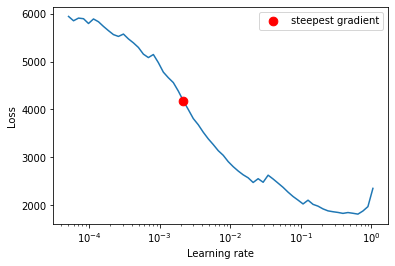

In [83]:
lr_finder.plot()
lr_finder.reset()

In [84]:
2.15E-03

0.00215

### Training

In [22]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [23]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [24]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 Parameter {} Training split:1000, Validation: 732'.format(parameter)
config.parameter = parameter

In [25]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [26]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)

        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse[0]})

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 4.422056674957275, train MSE: [4.422056674957275]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 0.1944793164730072, validation MSE: [0.1944793313741684]
Validation loss decreased (inf --> 0.194479).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 0.15095780789852142, train MSE: [0.15095782279968262]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 0.17814508080482483, validation MSE: [0.17814508080482483]
Validation loss decreased (0.194479 --> 0.178145).  Saving model ...


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 0.13368888199329376, train MSE: [0.13368889689445496]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 0.40638527274131775, validation MSE: [0.40638530254364014]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 0.11221041530370712, train MSE: [0.11221041530370712]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 0.07774323225021362, validation MSE: [0.07774323225021362]
Validation loss decreased (0.178145 --> 0.077743).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 0.10959449410438538, train MSE: [0.10959449410438538]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 0.08982399851083755, validation MSE: [0.08982399106025696]
EarlyStopping counter: 1 out of 13


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 0.09851013123989105, train MSE: [0.09851012378931046]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 0.09874051809310913, validation MSE: [0.09874053299427032]
EarlyStopping counter: 2 out of 13


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 0.13377869129180908, train MSE: [0.13377869129180908]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 0.1834070086479187, validation MSE: [0.1834070086479187]
EarlyStopping counter: 3 out of 13


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.1457054316997528, train MSE: [0.145705446600914]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 0.2883785367012024, validation MSE: [0.2883785367012024]
EarlyStopping counter: 4 out of 13


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 0.10427918285131454, train MSE: [0.10427919775247574]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 0.13741189241409302, validation MSE: [0.13741189241409302]
EarlyStopping counter: 5 out of 13


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 0.1010294035077095, train MSE: [0.1010294109582901]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 2.3387434482574463, validation MSE: [2.3387436866760254]
EarlyStopping counter: 6 out of 13


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.006, train loss: 0.09156691282987595, train MSE: [0.09156691282987595]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 0.15294590592384338, validation MSE: [0.1529458910226822]
EarlyStopping counter: 7 out of 13


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.006, train loss: 0.07171691209077835, train MSE: [0.07171691954135895]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 0.06786881387233734, validation MSE: [0.06786882132291794]
Validation loss decreased (0.077743 --> 0.067869).  Saving model ...


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.006, train loss: 0.09014222025871277, train MSE: [0.09014222025871277]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.06324119865894318, validation MSE: [0.06324119865894318]
Validation loss decreased (0.067869 --> 0.063241).  Saving model ...


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 0.08603756129741669, train MSE: [0.08603756874799728]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 1.2012686729431152, validation MSE: [1.2012686729431152]
EarlyStopping counter: 1 out of 13


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 0.07986175268888474, train MSE: [0.07986174523830414]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 0.09486096352338791, validation MSE: [0.09486096352338791]
EarlyStopping counter: 2 out of 13


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 0.08064830303192139, train MSE: [0.08064830303192139]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 0.0876312330365181, validation MSE: [0.0876312330365181]
EarlyStopping counter: 3 out of 13


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 0.08071199059486389, train MSE: [0.08071199059486389]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 0.9082999229431152, validation MSE: [0.9082999229431152]
EarlyStopping counter: 4 out of 13


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 0.08214633166790009, train MSE: [0.08214632421731949]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 0.24509066343307495, validation MSE: [0.24509067833423615]
EarlyStopping counter: 5 out of 13


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 0.09414689987897873, train MSE: [0.09414689987897873]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 0.08422920852899551, validation MSE: [0.08422920107841492]
EarlyStopping counter: 6 out of 13


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.0036, train loss: 0.0778331533074379, train MSE: [0.0778331533074379]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.6608378887176514, validation MSE: [0.6608379483222961]
EarlyStopping counter: 7 out of 13


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.0036, train loss: 0.08454535901546478, train MSE: [0.08454535156488419]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 0.873866617679596, validation MSE: [0.8738667368888855]
EarlyStopping counter: 8 out of 13


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.0036, train loss: 0.07444484531879425, train MSE: [0.07444485276937485]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 1.725035548210144, validation MSE: [1.7250356674194336]
EarlyStopping counter: 9 out of 13


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.0036, train loss: 0.0727444589138031, train MSE: [0.0727444589138031]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.21244008839130402, validation MSE: [0.21244008839130402]
EarlyStopping counter: 10 out of 13


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.0036, train loss: 0.08303219825029373, train MSE: [0.08303219079971313]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 0.3702903687953949, validation MSE: [0.3702903389930725]
EarlyStopping counter: 11 out of 13


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.0036, train loss: 0.08239685744047165, train MSE: [0.08239686489105225]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 0.11648626625537872, validation MSE: [0.11648625880479813]
EarlyStopping counter: 12 out of 13


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.00216, train loss: 0.07078798115253448, train MSE: [0.07078797370195389]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 0.09018875658512115, validation MSE: [0.09018875658512115]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [27]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [28]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_09_05_2022_Single_Parameter_pH.pth

In [31]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_09_05_2022_Single_Parameter_pH.pth')))

<All keys matched successfully>

In [32]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [65]:
modelLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [66]:
test_data = HyperViewDataset(None, os.path.join(
    test_data_directory), True, means, stds, train_transforms=False)

In [67]:
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4, shuffle=False)

In [68]:
len(test_data)

1154

In [69]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar:  # for each test step
    img_data_device = test_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    output_list.append(output_cpu)

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [70]:
submission = pd.DataFrame(
    data=[item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,68.586143,222.838531,171.396500,6.951674
1,68.586151,222.838547,171.396500,6.951673
2,68.586159,222.838547,171.396484,6.951674
3,68.586159,222.838623,171.396469,6.951674
4,68.586151,222.838516,171.396500,6.951673
...,...,...,...,...
1149,67.354424,217.670792,171.512131,6.525923
1150,68.368927,220.833267,170.940704,6.552281
1151,69.019394,222.623795,168.086761,6.488876
1152,68.054962,219.802689,170.666565,6.531305


In [71]:
submission.to_csv(os.path.join(submissions_directory,
                  "checkpoint_state_dict_ResNet50_07_05_2022.csv"), index_label="sample_index")